## Surveillance의 error를 포함해서 폐사체 재 조정 후 infected 추정

In [53]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# plot setting
plt.rcParams['font.family']='Arial'

bar_width=0.25
plt.rc('axes', labelsize=11)
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('legend', fontsize=8)
plt.rc('figure', titlesize=10) 
title_size = 18
label_size = 14
point_alpha = 0.8

color_vs = ['#E881A6', '#6EA1D4']
color_year2 = ['#FFBE98', '#FFA74F', '#E881A6', '#60C8B3', '#6EA1D4']
color_year = ['#EFCFBA', '#FFB2A5', '#FA9A85',  '#DE8286', '#F97272']

set_dpi=300



In [54]:
gpd_file_path = '../Data/'
gpd_file_name = 'sig_5179.shp'
loc_file_name = 'result2.csv'
car_file_name = 'ASF_Wildboar_Update.csv'

location = pd.read_csv(gpd_file_path + loc_file_name, encoding='cp949', index_col=0)
location.reset_index(inplace = True)
korea = gpd.read_file(gpd_file_path + gpd_file_name)
car = pd.read_csv(gpd_file_path + car_file_name)

korea = korea.to_crs(epsg=4326)
location_sum = len(location['SIG_CD'].unique())
time_sum = location.query('SIG_CD == 11110').shape[0]

ind = pd.date_range(start = '2019-10-01', end = '2023-05-01', freq = 'D')

# Set matrix to save information
car_mat = np.zeros((location_sum, time_sum)) # for carcasses
high_mat = np.zeros((location_sum, time_sum)) # for high carcasses
middle_mat = np.zeros((location_sum, time_sum)) # for middle carcasses
car_day_mat = np.zeros((location_sum, len(ind))) # for carcasses per day each region
high_day_mat = np.zeros((location_sum, len(ind))) # for high carcasses per day each region
middle_day_mat = np.zeros((location_sum, len(ind))) # for middle carcasses per day each region

car_day_df = pd.DataFrame(car_day_mat)
car_day_df.index = location['SIG_CD'].unique()
car_day_df.columns = ind
car['확진'] = pd.to_datetime(car['확진'], format='%Y-%m-%d').dt.normalize()

merged_data = car.merge(location.drop_duplicates(subset='SIG_ENG_NM_x'), left_on='시군구', right_on = 'SIG_ENG_NM_x', how='left')
merged_data['counts'] = 1
merged_col = ['신고(발견)', '확진', '시군구', 'SIG_CD', 'counts']
merged_data = merged_data[merged_col]
merged_sum = merged_data['SIG_CD'].unique()

merged_data = merged_data.set_index('확진', inplace=False)

for i in merged_sum:
    merged = merged_data.query('SIG_CD == @i').groupby('확진')['counts'].sum().resample('D').sum().reindex(ind, fill_value=0)
    car_day_df.loc[i, :] = merged

car_day_df_T = car_day_df.T
h = 0.5 # ratio
high_period = 4
middle_period = 16



In [55]:
lose_infection_period = 20

high_cumsum_mat = car_day_df_T * 0.5
middle_cumsum_mat = car_day_df_T * 0.5
high_cumsum_mat = high_cumsum_mat.shift(-high_period).fillna(0)
middle_cumsum_mat = middle_cumsum_mat.shift(-middle_period).fillna(0)
car_cumsum_mat = car_day_df_T * 1


for region in car_day_df_T.columns:
    dat = car_day_df_T.loc[:,region]
    for time in range(len(dat)-high_period):
        if dat[time] > 0:
            high_cumsum_mat.loc[:,region][(time+1):(time+high_period)] = high_cumsum_mat.loc[:,region][(time+1):(time+high_period)] + dat[time]
        else:
            pass

for region in car_day_df_T.columns:
    dat = car_day_df_T.loc[:,region]
    for time in range(len(dat)-middle_period):
        if dat[time] > 0:
            middle_cumsum_mat.loc[:,region][(time+1):(time+middle_period)] = middle_cumsum_mat.loc[:,region][(time+1):(time+middle_period)] + dat[time]
        else:
            pass

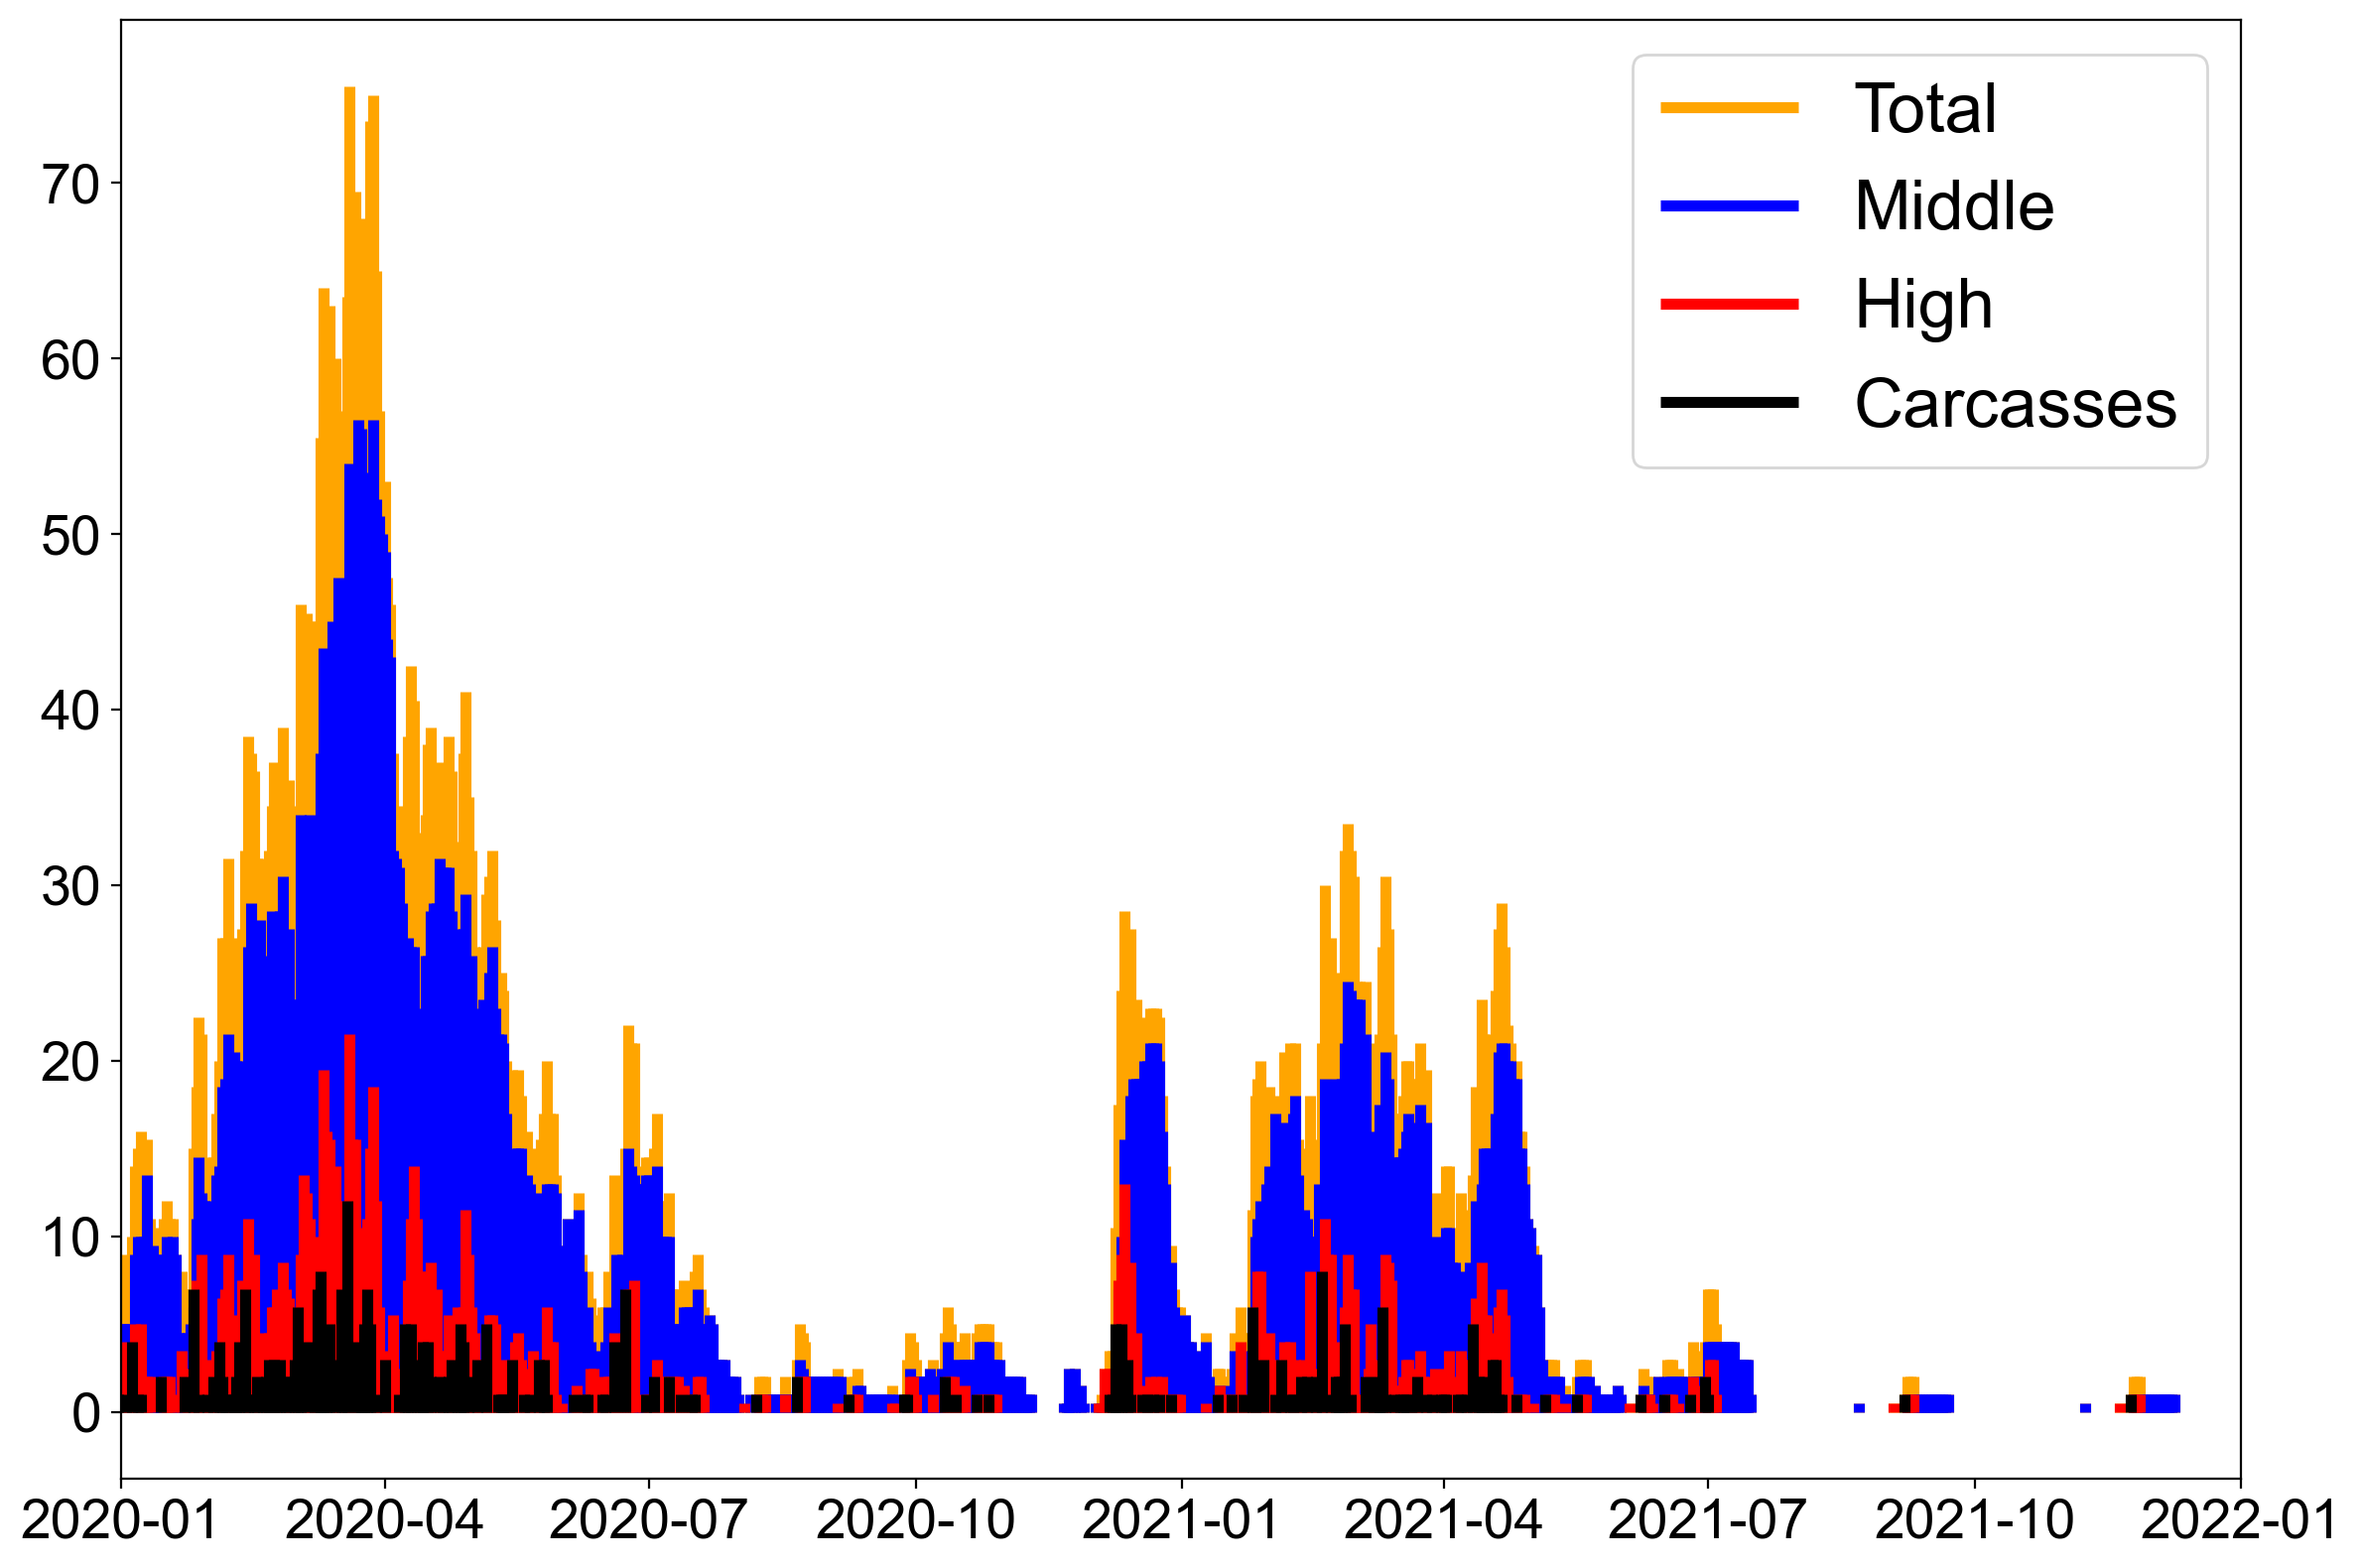

In [56]:
# plot
fig, ax = plt.subplots(figsize = (12, 8), dpi = 200)
ax.vlines(x=high_cumsum_mat.index, ymin=0, ymax=high_cumsum_mat.loc[:, 41800]+middle_cumsum_mat.loc[:, 41800]+car_cumsum_mat.loc[:, 41800]
          , label='Total', linewidth = 4, color = 'orange', alpha = 1)
ax.vlines(x=middle_cumsum_mat.index, ymin=0, ymax=middle_cumsum_mat.loc[:, 41800], label='Middle', linewidth = 4, color = 'blue', alpha = 1)
ax.vlines(x=high_cumsum_mat.index, ymin=0, ymax=high_cumsum_mat.loc[:, 41800], label='High', linewidth = 4, color = 'red', alpha = 1)
ax.vlines(x=car_cumsum_mat.index, ymin=0, ymax=car_cumsum_mat.loc[:, 41800], label='Carcasses', linewidth = 4, color = 'black', alpha = 1)
ax.set_xlim([pd.Timestamp('2020-01-01'), pd.Timestamp('2022-01-01')])
ax.legend(loc = 'upper right', fontsize = 25)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.tight_layout()
plt.show()

In [57]:
# 월별로 변환
car_monthly = car_cumsum_mat.resample('M').sum()
high_monthly = high_cumsum_mat.resample('M').sum()
middle_monthly = middle_cumsum_mat.resample('M').sum()

# 여기서부터 감시강도 + Infected 재추정

In [58]:
# 감시 강도 추가한 shp 파일 불러오기
add_surv = "korea_with_surveillance.shp"
korea = gpd.read_file(gpd_file_path + add_surv)

data_carcasses = pd.read_csv(gpd_file_path + 'result.csv', encoding='cp949', index_col=0)
data_carcasses.index = data_carcasses.index.astype(str)
data_carcasses

,distance,time,forest,season,NUMPOINTS,x,y
SIG_CD,,,,,,,
11110,0.529491,201910,956.0,1,0,126.977321,37.594917
11110,0.529491,201911,956.0,1,0,126.977321,37.594917
11110,0.529491,201912,956.0,1,0,126.977321,37.594917
11140,0.559611,201910,150.0,1,0,126.995968,37.560144
11140,0.559611,201911,150.0,1,0,126.995968,37.560144
...,...,...,...,...,...,...,...
50110,4.018824,202304,44499.0,0,0,126.529248,33.442202
50130,4.101871,202301,42835.0,1,0,126.581039,33.324982
50130,4.101871,202302,42835.0,1,0,126.581039,33.324982


In [61]:
# 기존 time 저장
original_time = data_carcasses['time']
data_carcasses['time'] = pd.to_datetime(data_carcasses['time'], format = '%Y%m')
data_carcasses['year'] = data_carcasses['time'].dt.year
data_carcasses['month'] = data_carcasses['time'].dt.month

# 연도별로 구분
data_2019_2 = data_carcasses.query('time < "2020-01-01"')
data_2020_1 = data_carcasses.query('time < "2020-07-01" & time >= "2020-01-01"')
data_2020_2 = data_carcasses.query('time < "2021-01-01" & time >= "2020-07-01"')
data_2021_1 = data_carcasses.query('time < "2021-07-01" & time >= "2021-01-01"')
data_2021_2 = data_carcasses.query('time < "2022-01-01" & time >= "2021-07-01"')
data_2022_1 = data_carcasses.query('time < "2022-07-01" & time >= "2022-01-01"')
data_2022_2 = data_carcasses.query('time < "2023-01-01" & time >= "2022-07-01"')
data_2023_1 = data_carcasses.query('time < "2023-07-01" & time >= "2023-01-01"')

data_2019_2 = data_2019_2.merge(korea.set_index('SIG_CD')[['2019_2']], left_on='SIG_CD', right_index=True, how='left')
data_2020_1 = data_2020_1.merge(korea.set_index('SIG_CD')[['2020_1']], left_on='SIG_CD', right_index=True, how='left')
data_2020_2 = data_2020_2.merge(korea.set_index('SIG_CD')[['2020_2']], left_on='SIG_CD', right_index=True, how='left')
data_2021_1 = data_2021_1.merge(korea.set_index('SIG_CD')[['2021_1']], left_on='SIG_CD', right_index=True, how='left')
data_2021_2 = data_2021_2.merge(korea.set_index('SIG_CD')[['2021_2']], left_on='SIG_CD', right_index=True, how='left')
data_2022_1 = data_2022_1.merge(korea.set_index('SIG_CD')[['2022_1']], left_on='SIG_CD', right_index=True, how='left')
data_2022_2 = data_2022_2.merge(korea.set_index('SIG_CD')[['2022_2']], left_on='SIG_CD', right_index=True, how='left')
data_2023_1 = data_2023_1.merge(korea.set_index('SIG_CD')[['2023_1']], left_on='SIG_CD', right_index=True, how='left')

data_2019_2['error'] = 0.05*(1/3)*(3-data_2019_2['2019_2'])*np.sqrt(data_2019_2['NUMPOINTS'])
data_2020_1['error'] = 0.05*(1/3)*(3-data_2020_1['2020_1'])*np.sqrt(data_2020_1['NUMPOINTS'])
data_2020_2['error'] = 0.05*(1/3)*(3-data_2020_2['2020_2'])*np.sqrt(data_2020_2['NUMPOINTS'])
data_2021_1['error'] = 0.05*(1/3)*(3-data_2021_1['2021_1'])*np.sqrt(data_2021_1['NUMPOINTS'])
data_2021_2['error'] = 0.05*(1/3)*(3-data_2021_2['2021_2'])*np.sqrt(data_2021_2['NUMPOINTS'])
data_2022_1['error'] = 0.05*(1/3)*(3-data_2022_1['2022_1'])*np.sqrt(data_2022_1['NUMPOINTS'])
data_2022_2['error'] = 0.05*(1/3)*(3-data_2022_2['2022_2'])*np.sqrt(data_2022_2['NUMPOINTS'])
data_2023_1['error'] = 0.05*(1/3)*(3-data_2023_1['2023_1'])*np.sqrt(data_2023_1['NUMPOINTS'])

data_2019_2.loc[data_2019_2['2019_2'] == 0, 'error'] = 0
data_2020_1.loc[data_2020_1['2020_1'] == 0, 'error'] = 0
data_2020_2.loc[data_2020_2['2020_2'] == 0, 'error'] = 0
data_2021_1.loc[data_2021_1['2021_1'] == 0, 'error'] = 0
data_2021_2.loc[data_2021_2['2021_2'] == 0, 'error'] = 0
data_2022_1.loc[data_2022_1['2022_1'] == 0, 'error'] = 0
data_2022_2.loc[data_2022_2['2022_2'] == 0, 'error'] = 0
data_2023_1.loc[data_2023_1['2023_1'] == 0, 'error'] = 0

# data_2019_2['NUMPOINTS'] = data_2019_2.apply(lambda x: x['NUMPOINTS'] + 0.1*x['2019_2']*np.sqrt(x['NUMPOINTS']), axis=1)
# data_2020_1['NUMPOINTS'] = data_2020_1.apply(lambda x: x['NUMPOINTS'] + 0.1*x['2020_1']*np.sqrt(x['NUMPOINTS']), axis=1)
# data_2020_2['NUMPOINTS'] = data_2020_2.apply(lambda x: x['NUMPOINTS'] + 0.1*x['2020_2']*np.sqrt(x['NUMPOINTS']), axis=1)
# data_2021_1['NUMPOINTS'] = data_2021_1.apply(lambda x: x['NUMPOINTS'] + 0.1*x['2021_1']*np.sqrt(x['NUMPOINTS']), axis=1)
# data_2021_2['NUMPOINTS'] = data_2021_2.apply(lambda x: x['NUMPOINTS'] + 0.1*x['2021_2']*np.sqrt(x['NUMPOINTS']), axis=1)
# data_2022_1['NUMPOINTS'] = data_2022_1.apply(lambda x: x['NUMPOINTS'] + 0.1*x['2022_1']*np.sqrt(x['NUMPOINTS']), axis=1)
# data_2022_2['NUMPOINTS'] = data_2022_2.apply(lambda x: x['NUMPOINTS'] + 0.1*x['2022_2']*np.sqrt(x['NUMPOINTS']), axis=1)
# data_2023_1['NUMPOINTS'] = data_2023_1.apply(lambda x: x['NUMPOINTS'] + 0.1*x['2023_1']*np.sqrt(x['NUMPOINTS']), axis=1)

In [62]:
import random

def random_float_partition(k, n):
    """
    Randomly partition the value k into n positive floating-point numbers.
    
    Args:
    k (float): The value to partition.
    n (int): The number of partitions.
    
    Returns:
    list: A list of n positive floating-point numbers that sum to k.
    """
    # Generate n-1 random points within the range 0 and k
    points = sorted([random.uniform(0, k) for _ in range(n-1)])
    
    # Add the start and end points
    points = [0] + points + [k]
    
    # Calculate the differences between consecutive points
    partition = [points[i+1] - points[i] for i in range(n)]
    
    # Ensure all values are positive
    if all(p > 0 for p in partition):
        return partition
    else:
        return random_float_partition(k, n)


In [63]:
# 열별로 감시강도에 따라 오차 지정하기

# 2019년 10월 1일부터 11월 1일 전까지의 data length
from datetime import datetime

def add_error_day(data1, start_date, end_date, month, year):
    n = (end_date-start_date).days
    used_data = data1.query('year == @year & month == @month')
    error = used_data['error']
    mat = pd.DataFrame(np.zeros((n, len(error))))

    for i in range(len(error)):
        if error[i] == 0:
            mat.iloc[:, i] = 0
        else:
            mat.iloc[:n, i] = random_float_partition(k=error[i], n=n)

    return mat

months = np.arange(1, 13)
years = np.arange(2020, 2023)

day_2019 = pd.concat([add_error_day(data_2019_2, datetime(2019, 10, 1), datetime(2019, 11, 1), 10, 2019),
           add_error_day(data_2019_2, datetime(2019, 11, 1), datetime(2019, 12, 1), 11, 2019),
           add_error_day(data_2019_2, datetime(2019, 12, 1), datetime(2020, 1, 1), 12, 2019) ], axis=0)

b = []
for year in years:
    for month in months:
        if month <= 6:
            day_2020 = pd.concat([add_error_day(globals()['data_' + str(year) + '_1'], datetime(year, month, 1), datetime(year, month+1, 1), month, year)], axis=0)
        elif month == 12:
            day_2020 = pd.concat([add_error_day(globals()['data_' + str(year) + '_2'], datetime(year, month, 1), datetime(year+1, 1, 1), month, year)], axis=0)
        else:
            day_2020 = pd.concat([add_error_day(globals()['data_' + str(year) + '_2'], datetime(year, month, 1), datetime(year, month+1, 1), month, year)], axis=0)
        b.append(day_2020)
day_2020_2022 = pd.concat(b, axis=0)

day_2023 = pd.concat([add_error_day(data_2023_1, datetime(2023, 1, 1), datetime(2023, 2, 1), 1, 2023),
              add_error_day(data_2023_1, datetime(2023, 2, 1), datetime(2023, 3, 1), 2, 2023),
              add_error_day(data_2023_1, datetime(2023, 3, 1), datetime(2023, 4, 1), 3, 2023),
              add_error_day(data_2023_1, datetime(2023, 4, 1), datetime(2023, 5, 1), 4, 2023)], axis=0)

day_car = pd.concat([day_2019, day_2020_2022, day_2023], axis=0)

In [64]:
day_car = day_car.reset_index(drop=True, inplace=False)
day_car.index = car_day_df_T.index[:-1]
day_car.columns = car_day_df_T.columns

In [65]:
lose_infection_period = 20
day_car = day_car + car_day_df_T

high_period = 4
middle_period = 10

high_cumsum_mat = (day_car) * 0.5
middle_cumsum_mat = (day_car) * 0.5
high_cumsum_mat = high_cumsum_mat.shift(-high_period).fillna(0)
middle_cumsum_mat = middle_cumsum_mat.shift(-middle_period).fillna(0)
car_cumsum_mat = (day_car) * 1


for region in day_car.columns:
    dat = day_car.loc[:,region]
    for time in range(len(dat)-high_period):
        if dat[time] > 0:
            high_cumsum_mat.loc[:,region][(time+1):(time+high_period)] = high_cumsum_mat.loc[:,region][(time+1):(time+high_period)] + dat[time]
        else:
            pass

for region in day_car.columns:
    dat = day_car.loc[:,region]
    for time in range(len(dat)-middle_period):
        if dat[time] > 0:
            middle_cumsum_mat.loc[:,region][(time+1):(time+middle_period)] = middle_cumsum_mat.loc[:,region][(time+1):(time+middle_period)] + dat[time]
        else:
            pass

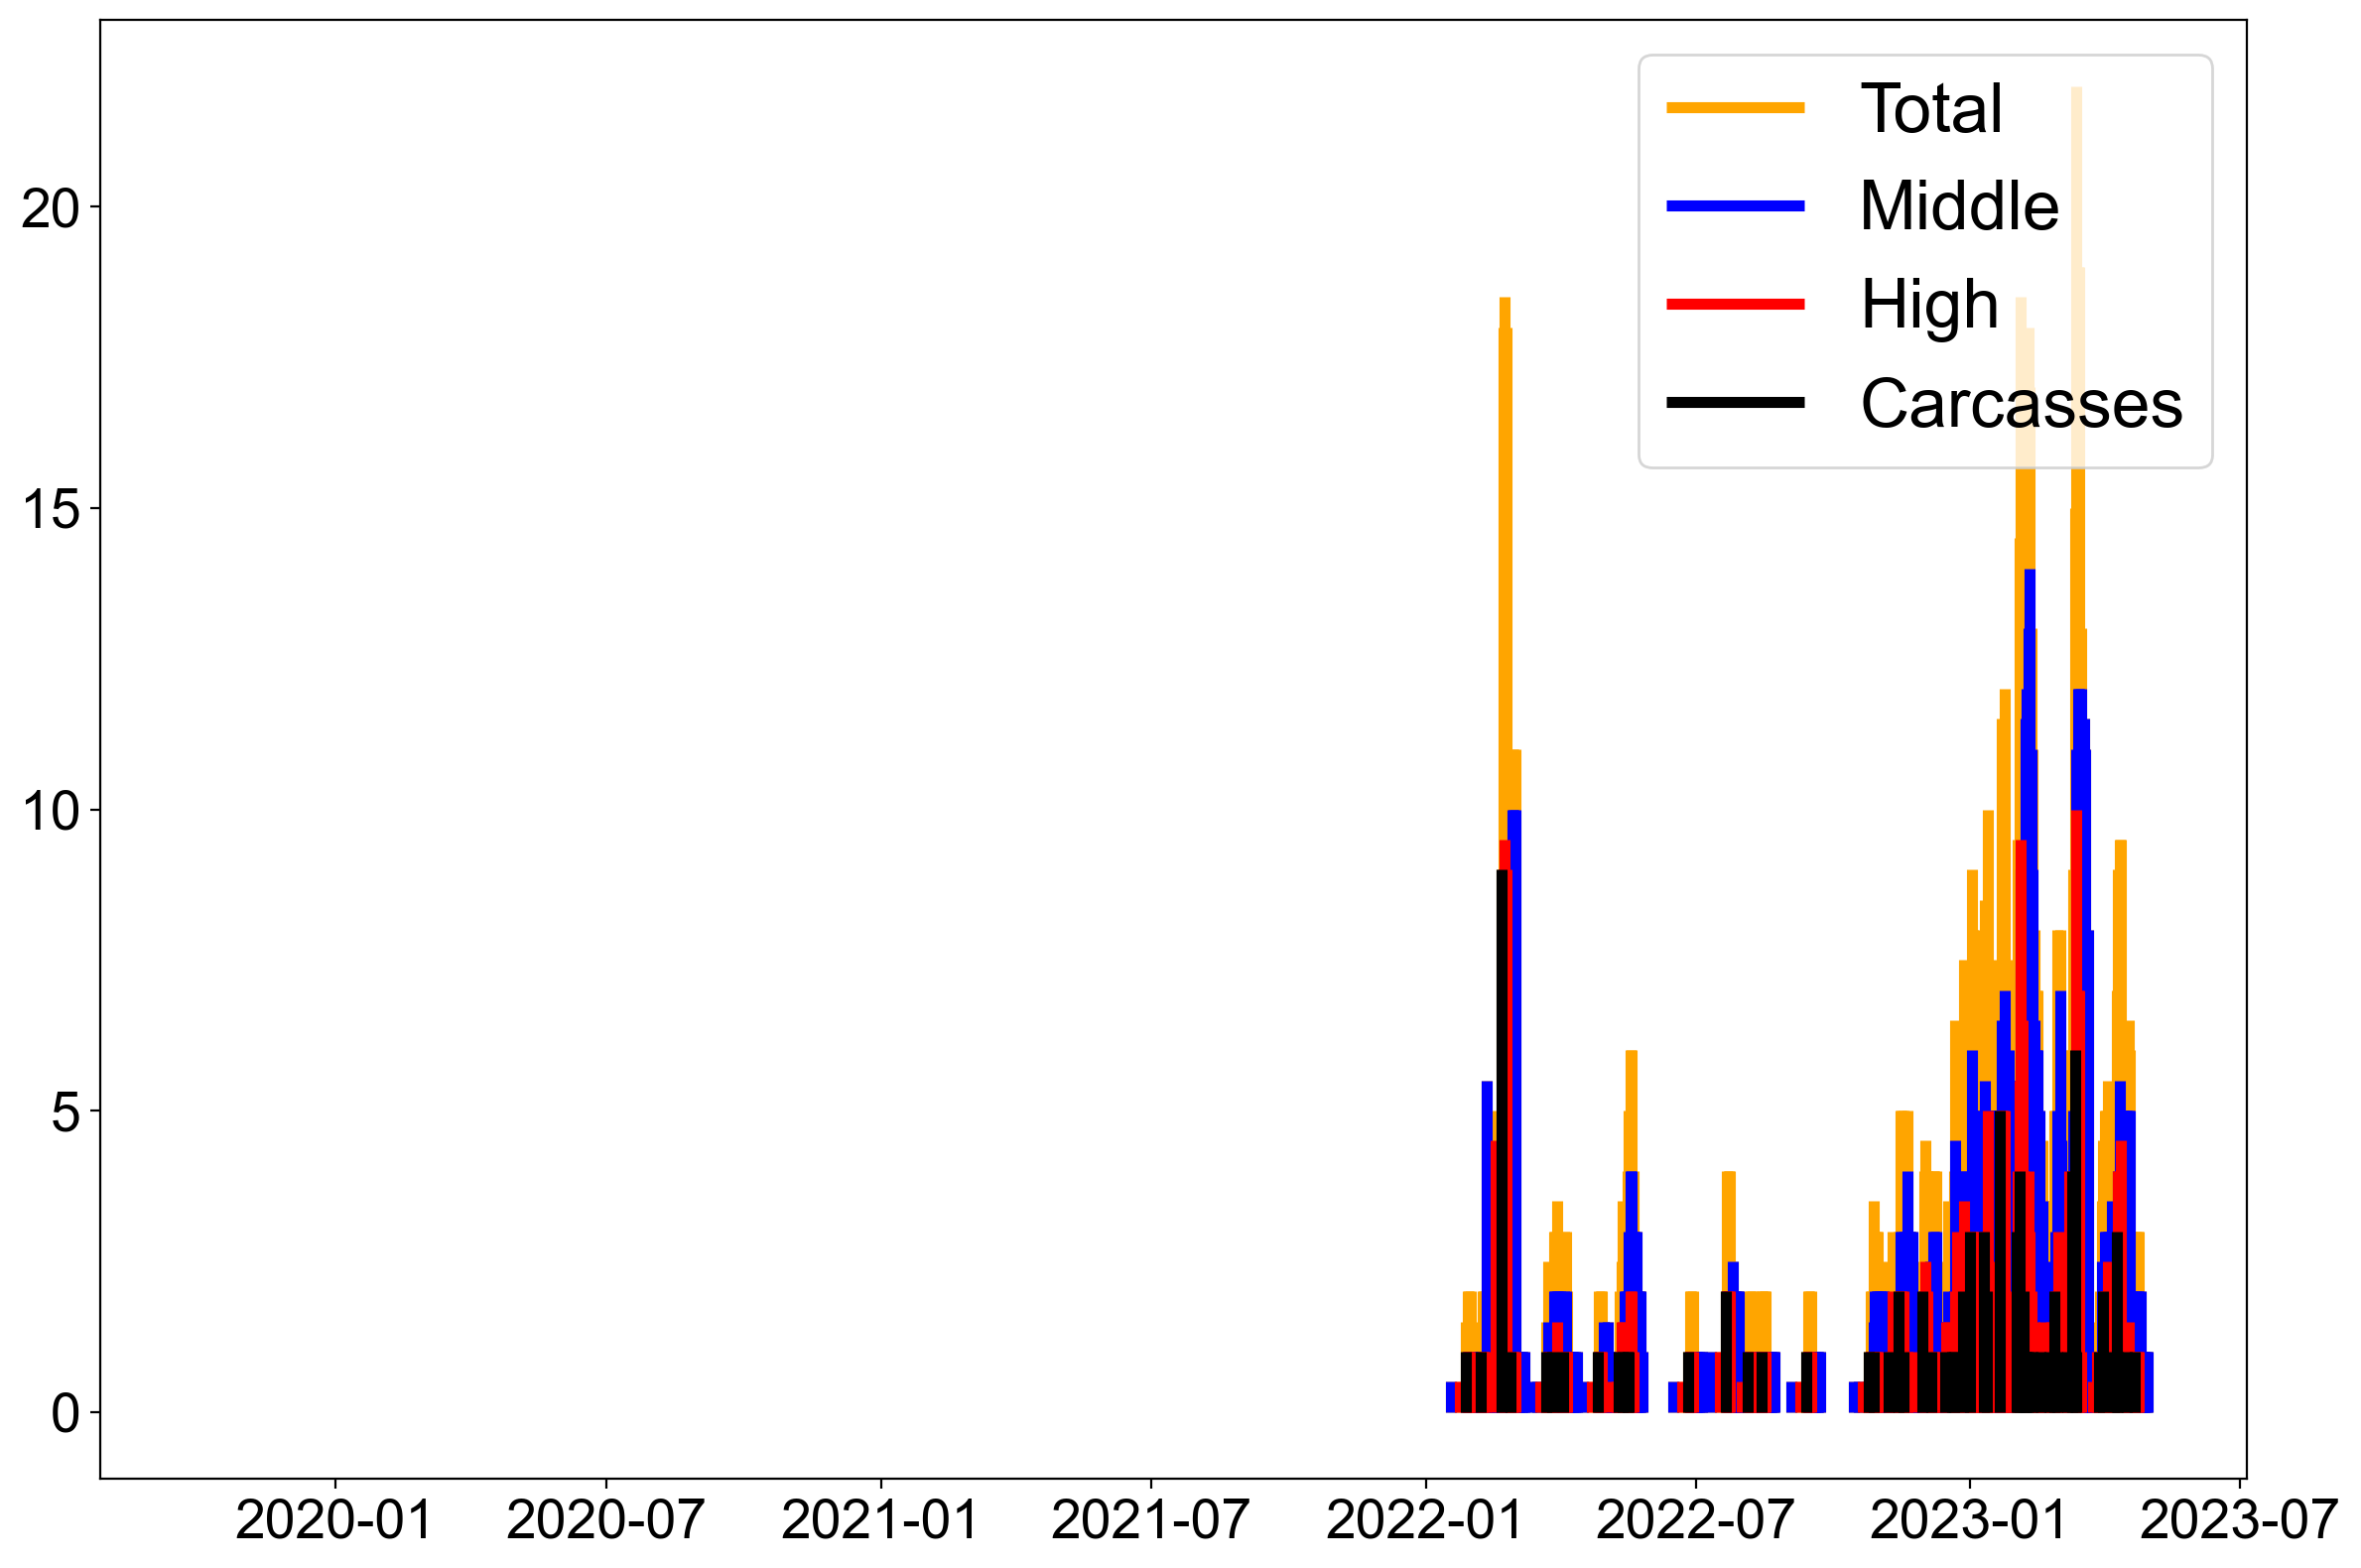

In [66]:
# plot
fig, ax = plt.subplots(figsize = (12, 8), dpi = 200)
ax.vlines(x=high_cumsum_mat.index, ymin=0, ymax=high_cumsum_mat.loc[:, 43130]+middle_cumsum_mat.loc[:, 43130]+car_cumsum_mat.loc[:, 43130]
          , label='Total', linewidth = 4, color = 'orange', alpha = 1)
ax.vlines(x=middle_cumsum_mat.index, ymin=0, ymax=middle_cumsum_mat.loc[:, 43130], label='Middle', linewidth = 4, color = 'blue', alpha = 1)
ax.vlines(x=high_cumsum_mat.index, ymin=0, ymax=high_cumsum_mat.loc[:, 43130], label='High', linewidth = 4, color = 'red', alpha = 1)
ax.vlines(x=car_cumsum_mat.index, ymin=0, ymax=car_cumsum_mat.loc[:, 43130], label='Carcasses', linewidth = 4, color = 'black', alpha = 1)

ax.legend(loc = 'upper right', fontsize = 25)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.tight_layout()
plt.show()

In [67]:
# 월별로 변환
car_monthly = car_cumsum_mat.resample('M').mean()
car_monthly = car_monthly.iloc[:-1, :]
high_monthly = high_cumsum_mat.resample('M').mean()
high_monthly = high_monthly.iloc[:-1, :]
middle_monthly = middle_cumsum_mat.resample('M').mean()
middle_monthly = middle_cumsum_mat.resample('M').mean()
total_monthly = car_monthly + high_monthly + middle_monthly
total_monthly = total_monthly.iloc[:-1, :]

In [68]:
total_monthly.index = total_monthly.index.to_period('M').to_timestamp()
car_monthly.index = car_monthly.index.to_period('M').to_timestamp()
high_monthly.index = high_monthly.index.to_period('M').to_timestamp()
middle_monthly.index = middle_monthly.index.to_period('M').to_timestamp()


In [69]:
data_carcass = data_carcasses.groupby(['time', 'SIG_CD']).sum().reset_index()
data_carcass['SIG_CD'] = data_carcass['SIG_CD'].astype(int)
data_carcass = data_carcass.sort_values(by = ['SIG_CD', 'time'])
data_carcass['total'] = total_monthly.stack().reset_index().sort_values(by = ['level_1', 'level_0'])[0]
data_carcass['carcasses'] = car_monthly.stack().reset_index().sort_values(by = ['level_1', 'level_0'])[0]
data_carcass['high'] = high_monthly.stack().reset_index().sort_values(by = ['level_1', 'level_0'])[0]
data_carcass['middle'] = middle_monthly.stack().reset_index().sort_values(by = ['level_1', 'level_0'])[0]

In [70]:
data_carcass.loc[data_carcass['SIG_CD'] == 41650, :]

,time,SIG_CD,distance,forest,season,NUMPOINTS,x,y,year,month,total,carcasses,high,middle
112,2019-10-01,41650,0.205581,53199.0,1,0,127.250337,37.969778,2019,10,0.000000,0.000000,0.000000,0.000000
362,2019-11-01,41650,0.205581,53199.0,1,0,127.250337,37.969778,2019,11,0.000000,0.000000,0.000000,0.000000
612,2019-12-01,41650,0.205581,53199.0,1,0,127.250337,37.969778,2019,12,0.000000,0.000000,0.000000,0.000000
862,2020-01-01,41650,0.197909,53199.0,1,0,127.250337,37.969778,2020,1,0.000000,0.000000,0.000000,0.000000
1112,2020-02-01,41650,0.197909,53199.0,1,0,127.250337,37.969778,2020,2,0.000000,0.000000,0.000000,0.000000
1362,2020-03-01,41650,0.197909,53199.0,1,0,127.250337,37.969778,2020,3,0.000000,0.000000,0.000000,0.000000
1612,2020-04-01,41650,0.197909,53199.0,0,2,127.250337,37.969778,2020,4,0.866667,0.066667,0.233333,0.566667
1862,2020-05-01,41650,0.197909,53199.0,0,1,127.250337,37.969778,2020,5,0.516129,0.032258,0.112903,0.370968
2112,2020-06-01,41650,0.197909,53199.0,0,2,127.250337,37.969778,2020,6,0.716667,0.066667,0.200000,0.450000
2362,2020-07-01,41650,0.197909,53199.0,0,10,127.250337,37.969778,2020,7,3.854839,0.322581,1.145161,2.387097


In [71]:
data_carcass.to_csv(gpd_file_path + 'data_carcass.csv', index = False)

In [72]:
# # 2019년
# car_monthly.iloc[0,] = data_2019_2.query('time < "2019-11-01"')['NUMPOINTS']
# car_monthly.iloc[1,] = data_2019_2.query('time < "2019-12-01" & time >= "2019-11-01"')['NUMPOINTS']
# car_monthly.iloc[2,] = data_2019_2.query('time < "2020-01-01" & time >= "2019-12-01"')['NUMPOINTS']
# a = 2

# # 2020년 1월 ~ 6월
# for month in range(1, 7):
#     car_monthly.iloc[a+month, :] = data_2020_1.query('time < "2020-0'+str(month+1)+'-01" & time >= "2020-0'+str(month)+'-01"')['NUMPOINTS']
    

# # 2020년 7월 ~ 12월
# for month in range(7, 13):
#     if month < 9:
#         car_monthly.iloc[(a+6)+month-6, :] = data_2020_2.query('time < "2020-0'+str(month+1)+'-01" & time >= "2020-0'+str(month)+'-01"')['NUMPOINTS']
        
#     elif month == 9:
#         car_monthly.iloc[(a+6)+month-6, :] = data_2020_2.query('time < "2020-'+str(month+1)+'-01" & time >= "2020-0'+str(month)+'-01"')['NUMPOINTS']
        
#     elif month == 12:
#         car_monthly.iloc[(a+6)+month-6, :] = data_2020_2.query('time < "2021-0'+str(month-11)+'-01" & time >= "2020-'+str(month)+'-01"')['NUMPOINTS']
        
#     else:
#         car_monthly.iloc[(a+6)+month-6, :] = data_2020_2.query('time < "2020-'+str(month+1)+'-01" & time >= "2020-'+str(month)+'-01"')['NUMPOINTS']
        

# # 2021년 1월 ~ 6일
# for month in range(1, 7):
#     car_monthly.iloc[(a+12)+month, :] = data_2021_1.query('time < "2021-0'+str(month+1)+'-01" & time >= "2021-0'+str(month)+'-01"')['NUMPOINTS']
    

# # 2021년 7월 ~ 12월
# for month in range(7, 13):
#     if month < 9:
#         car_monthly.iloc[(a+18)+month-6, :] = data_2021_2.query('time < "2021-0'+str(month+1)+'-01" & time >= "2021-0'+str(month)+'-01"')['NUMPOINTS']
        
#     elif month == 9:
#         car_monthly.iloc[(a+18)+month-6, :] = data_2021_2.query('time < "2021-'+str(month+1)+'-01" & time >= "2021-0'+str(month)+'-01"')['NUMPOINTS']
        
#     elif month == 12:
#         car_monthly.iloc[(a+18)+month-6, :] = data_2021_2.query('time < "2022-0'+str(month-11)+'-01" & time >= "2021-'+str(month)+'-01"')['NUMPOINTS']
        
#     else:
#         car_monthly.iloc[(a+18)+month-6, :] = data_2021_2.query('time < "2021-'+str(month+1)+'-01" & time >= "2021-'+str(month)+'-01"')['NUMPOINTS']
        

# # 2022년 1월 ~ 6월
# for month in range(1, 7):
#     car_monthly.iloc[(a+24)+month, :] = data_2022_1.query('time < "2022-0'+str(month+1)+'-01" & time >= "2022-0'+str(month)+'-01"')['NUMPOINTS']

# # 2022년 7월 ~ 12월
# for month in range(7, 13):
#     if month < 9:
#         car_monthly.iloc[(a+30)+month-6, :] = data_2022_2.query('time < "2022-0'+str(month+1)+'-01" & time >= "2022-0'+str(month)+'-01"')['NUMPOINTS']
        
#     elif month == 9:
#         car_monthly.iloc[(a+30)+month-6, :] = data_2022_2.query('time < "2022-'+str(month+1)+'-01" & time >= "2022-0'+str(month)+'-01"')['NUMPOINTS']
        
#     elif month == 12:
#         car_monthly.iloc[(a+30)+month-6, :] = data_2022_2.query('time <= "2023-'+str(month)+'-30" & time >= "2022-'+str(month)+'-01"')['NUMPOINTS']
        
#     else:
#         car_monthly.iloc[(a+30)+month-6, :] = data_2022_2.query('time < "2022-'+str(month+1)+'-01" & time >= "2022-'+str(month)+'-01"')['NUMPOINTS']
        

# # 2023년
# for month in range(1, 5):
#     car_monthly.iloc[(a+36)+month, :] = data_2023_1.query('time < "2023-0'+str(month+1)+'-01" & time >= "2023-0'+str(month)+'-01"')['NUMPOINTS']